# CycleGAN Implementation

The purpose of this notebook is to refamiliarize myself with PyTorch 1.x by implementing a CycleGAN from scratch by referring to [the original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et al. Please refer to the paper if you have any questions on how the model works, as I will only be adding comments with the assumption that the reader already has a basic understanding of the 'why'.

The task will be to create domain transfer between summer and winter images from Yosemite Park. The data we will be working with can be found [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip). The implementation will adhere to the following structure:

1. Import Dependencies and Data
2. Set up the Data Loaders
3. Preprocess the Data
4. Define the Discriminator Architecture
5. Define the Generator Architecture
6. Complete the Model
7. Define the Loss Functions and Optimizers
8. Train the Model
9. Evaluate the Model
10. Discussion

## 1. Import and Visualize the Data

In [0]:
# Importing necessary dependencies
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Neural network imports
import torch.nn as nn
import torch.nn.functional as F

# For visualization purposes
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [0]:
# Useful function for visualization
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
# Using Colab for this implementation, thus need to manually download the data
# and unzip it in the next cell to avoid output clutter.
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip

--2020-05-08 11:00:56--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.135.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.135.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  16.8MB/s    in 9.0s    

2020-05-08 11:01:06 (14.1 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [0]:
!unzip /content/summer2winter-yosemite.zip

## 2. Set up the Data Loaders

In [0]:
# Modulate the function to get our data loaders

def get_data_loader(image_type, image_dir,
                    image_size = 128,
                    batch_size = 32,
                    num_workers = 0):
  """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
  These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
  """

  # resize and normalize
  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])

  # get training and test directories
  train_path = os.path.join(image_dir, image_type)
  test_path = os.path.join(image_dir, 'test_{}'.format(image_type))

  # define dataset folders
  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  # create and return the data loaders
  train_loader = DataLoader(train_dataset, batch_size = batch_size,
                            shuffle = True, num_workers = 0)
  test_loader = DataLoader(test_dataset, batch_size = batch_size,
                           shuffle = False, num_workers = 0)

  return train_loader, test_loader

In [0]:
# Setting up the X data loaders
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer',
                                                  image_dir = '/content/summer2winter_yosemite')

# Setting up the Y data loaders
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter',
                                                  image_dir = '/content/summer2winter_yosemite')

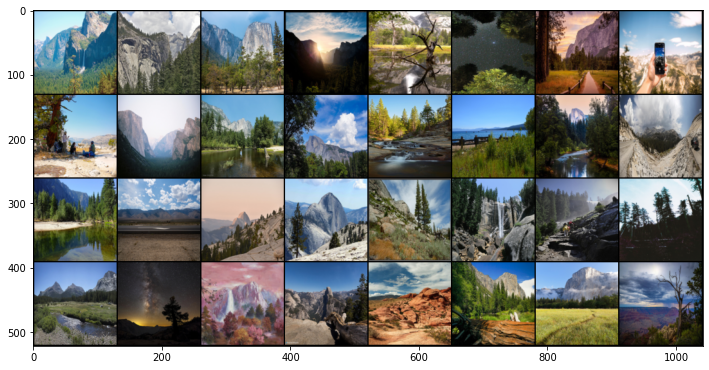

In [25]:
# Checking images from X
dataiter = iter(dataloader_X)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

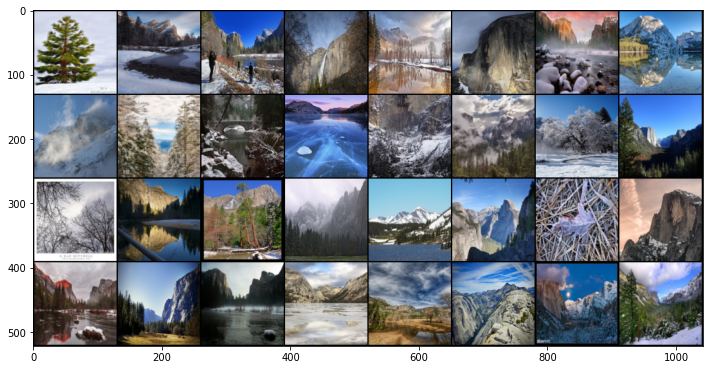

In [26]:
# Checking images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

## 3. Preprocess the Data

In [0]:
# Honestly a bit laughable about how little preprocessing is needed.

# Scale images from [0, 1] to [-1, 1].
def tanh_scale(x): return x * 2 - 1

In [33]:
# Sanity Check
img = images[0]

# Before
print('Min: ', img.min())
print('Max: ', img.max())

# After
scaled_img = tanh_scale(img)
print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Min:  tensor(0.0196)
Max:  tensor(0.9961)
Scaled min:  tensor(-0.9608)
Scaled max:  tensor(0.9922)


## 4. Define the Discriminator Architecture

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/discriminator_layers.png?raw=true' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

In [0]:
# helper conv function
def conv(in_channels, out_channels, kernel_size,
         stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                         kernel_size = kernel_size, stride = stride,
                         padding = padding, bias = False)
  
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))

  return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):

  def __init__(self, dim = 64):
    super(Discriminator, self).__init__()

    self.conv1 = conv(3, dim, 4, batch_norm = False)
    self.conv2 = conv(dim, dim*2, 4)
    self.conv3 = conv(dim*2, dim*4, 4)
    self.conv4 = conv(dim*4, dim*8, 4)
    self.conv5 = conv(dim*8, 1, 4, stride = 1, batch_norm = False)


  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.conv5(out)
    return out